In [1]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg

libdecor-gtk-WARNING: Failed to initialize GTK
Failed to load plugin 'libdecor-gtk.so': failed to init


""

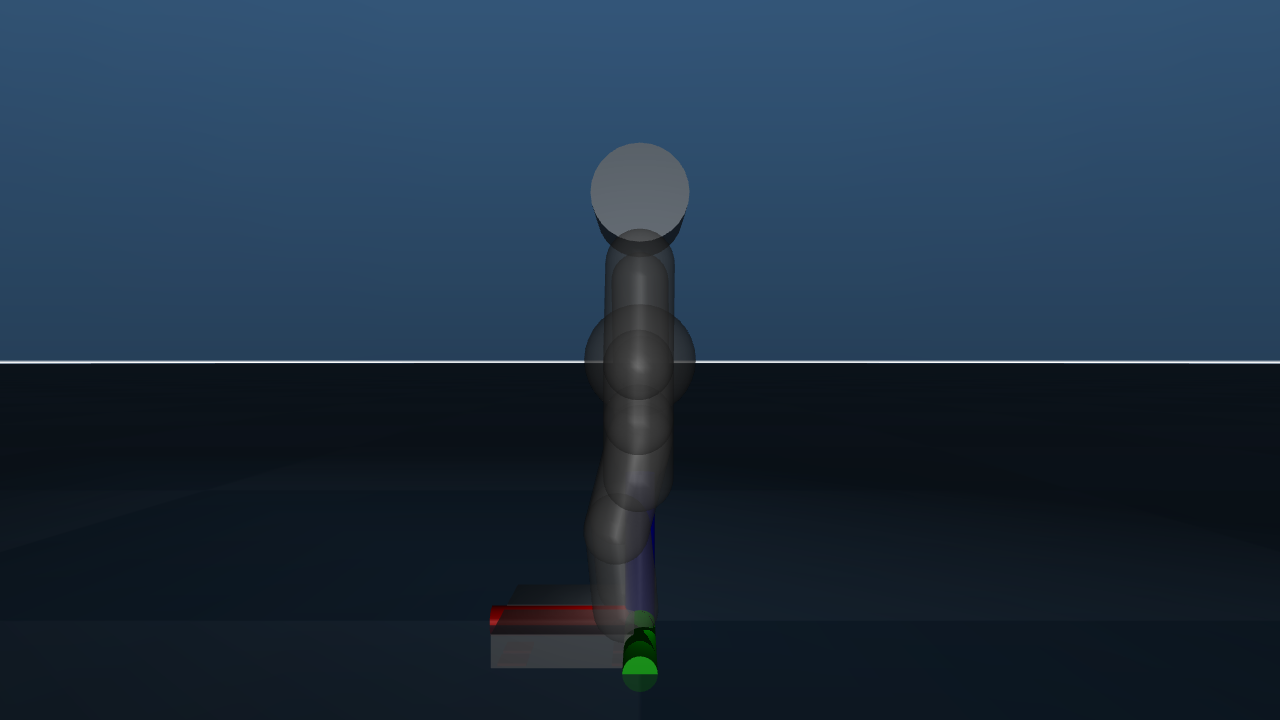

In [6]:
mujoco.mj_resetDataKeyframe(model, data, 1)
with mujoco.Renderer(model, width=1280, height=720) as renderer:
    scene_option = mujoco.MjvOption()
    scene_option.frame = (
        mujoco.mjtFrame.mjFRAME_WORLD | mujoco.mjtFrame.mjFRAME_BODY
    )
    mujoco.mj_forward(model, data)
    renderer.update_scene(data, "robot", scene_option)
    media.show_image(renderer.render())

In [8]:
DURATION = 3  # seconds
FRAMERATE = 60  # Hz

# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2

mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
accel_data = []
gyro_data = []
with mujoco.Renderer(model, width=1280, height=720) as renderer:
    while data.time < DURATION:
        # Set control vector.
        # data.ctrl = np.random.randn(model.nu) * 0.5

        # Step the simulation.
        mujoco.mj_step(model, data)
        accel_data.append(data.sensor("accelerometer").data.copy())
        gyro_data.append(data.sensor("gyroscope").data.copy())

        # Render and save frames.
        if len(frames) < data.time * FRAMERATE:
            # Set the lookat point to the humanoid's center of mass.
            camera.lookat = data.body("torso").subtree_com

            renderer.update_scene(data, camera)
            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

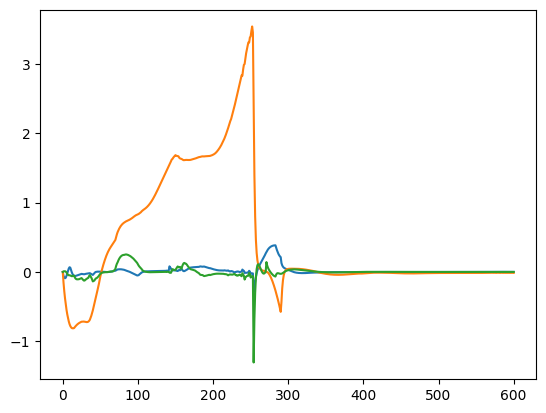

In [10]:
plt.plot(gyro_data)

In [11]:
from walking import (
    Parameters,
    Measurements,
    Control,
    Feet,
    Pose2,
    State,
    Side,
    step,
)
from inverse_kinematics import leg_angles, LegJoints, foot_to_isometry
from nao import Nao

In [13]:
with open("nao.xml", "r") as f:
    xml = f.read()

model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

DURATION = 3  # seconds
FRAMERATE = 60  # Hz
dt = model.opt.timestep

# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1


mujoco.mj_resetDataKeyframe(model, data, 0)
root = data.joint("root").qpos.copy()
nao_joint_interface = Nao(model, data)

left_lifts = []
right_lifts = []

frames = []
with mujoco.Renderer(model, width=1280, height=720) as renderer:
    while data.time < DURATION:
        state, left_sole, left_lift, right_sole, right_lift = step(
            state,
            measurements,
            control,
            dt,
            parameters,
        )
        left_leg_joints, right_leg_joints = leg_angles(
            foot_to_isometry(left_sole, left_lift),
            foot_to_isometry(right_sole, right_lift),
        )

        if left_lift < 0.001:
            measurements.pressure_left = 1.0
        else:
            measurements.pressure_left = 0.0

        if right_lift < 0.001:
            measurements.pressure_right = 1.0
        else:
            measurements.pressure_right = 0.0

        left_lifts.append(left_lift)
        right_lifts.append(right_lift)

        nao_joint_interface.actuators.left_leg.ankle_pitch = (
            left_leg_joints.ankle_pitch
        )
        nao_joint_interface.actuators.left_leg.ankle_roll = (
            left_leg_joints.ankle_roll
        )
        nao_joint_interface.actuators.left_leg.knee_pitch = (
            left_leg_joints.knee_pitch
        )
        nao_joint_interface.actuators.left_leg.hip_pitch = (
            left_leg_joints.hip_pitch
        )
        nao_joint_interface.actuators.left_leg.hip_roll = (
            left_leg_joints.hip_roll
        )
        nao_joint_interface.actuators.left_leg.hip_yaw_pitch = (
            left_leg_joints.hip_yaw_pitch
        )

        nao_joint_interface.actuators.right_leg.ankle_pitch = (
            right_leg_joints.ankle_pitch
        )
        nao_joint_interface.actuators.right_leg.ankle_roll = (
            right_leg_joints.ankle_roll
        )
        nao_joint_interface.actuators.right_leg.knee_pitch = (
            right_leg_joints.knee_pitch
        )
        nao_joint_interface.actuators.right_leg.hip_pitch = (
            right_leg_joints.hip_pitch
        )
        nao_joint_interface.actuators.right_leg.hip_roll = (
            right_leg_joints.hip_roll
        )
        nao_joint_interface.actuators.right_leg.hip_yaw_pitch = (
            right_leg_joints.hip_yaw_pitch
        )

        data.joint("root").qpos = root

        # Step the simulation.
        mujoco.mj_step(model, data)

        # Render and save frames.
        if len(frames) < data.time * FRAMERATE:
            # Set the lookat point to the humanoid's center of mass.
            point_of_interest = data.body("torso").subtree_com
            camera.lookat = point_of_interest
            camera.elevation = point_of_interest[2]
            camera.azimuth = 90.0  # set to 180 to view from the front

            renderer.update_scene(data, camera)
            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

/home/ole/hulk-stuff/hulk/tools/machine-learning/mujoco/inverse_kinematics.py:208: RuntimeWarning: invalid value encountered in arcsin
  ankle_roll=np.arcsin(-right_foot_rotation_c2[1]),


/home/ole/hulk-stuff/hulk/tools/machine-learning/mujoco/inverse_kinematics.py:197: RuntimeWarning: invalid value encountered in arcsin
  ankle_roll=np.arcsin(-left_foot_rotation_c2[1]),
